# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [36]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import cv2
import matplotlib.pyplot as plt

In [37]:
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten,TimeDistributed, BatchNormalization, Activation, Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l1,l2


We set the random seed so that the results don't vary drastically.

In [38]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [39]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

In [40]:
#Defining Hyperparameters
rows = 120   # X 
cols = 120   # Y 
channel = 3  # number of channels in images 3 for color(RGB)
frames=10
#num_epochs= 50

In [41]:

#data resizing - Resizing all the images, so we can have all the images in a specific size
def crop_resize_img(img):
    if img.shape[0] != img.shape[1]:
        img=img[0:120,10:150]
    resized_image = resize(img, (rows,cols))
    return resized_image

In [42]:
def plot(history):
          
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [43]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,29,frames)).astype(int)#create a list of image numbers you want to use for a particular video
    print(len(img_idx))
    while True:
                 
        t = np.random.permutation(folder_list)
        x=len(img_idx)
        y=120
        z=120
        num_batches = len(folder_list)//batch_size# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,frames,rows,cols,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #cropping the images
                    #image_cropped =image[80:360,30:360,:]
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = crop_resize_img(image)
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                #print(batch_labels.shape)  
                #print(batch_labels)            
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
             
        if (len(folder_list) != batch_size*num_batches):
             print("Batch: ",num_batches+1,"Index:", batch_size)
             batch_size = len(folder_list) - (batch_size*num_batches)
             batch_data = np.zeros((batch_size,frames,rows,cols,channel))
             batch_labels = np.zeros((batch_size,5))
             for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    #image_cropped =image[80:360,30:360,:]
                    image_resized = crop_resize_img(image)
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                #print(batch_labels.shape)
                            
        yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [44]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs= 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### 1.Conv3D

In [66]:

# ##conv3d

# #write your model here
model_conv3d = Sequential()

model_conv3d.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(frames,rows,cols,channel)))
model_conv3d.add(BatchNormalization())
model_conv3d.add(Activation('relu'))

model_conv3d.add(MaxPooling3D(pool_size=(2,2,2)))

model_conv3d.add(Conv3D(32, (2, 2, 2), padding='same'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(Activation('relu'))

model_conv3d.add(MaxPooling3D(pool_size=(2,2,2)))

model_conv3d.add(Conv3D(64, (2, 2, 2), padding='same'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(Activation('relu'))

model_conv3d.add(MaxPooling3D(pool_size=(2,2,2)))

model_conv3d.add(Conv3D(128, (2, 2, 2), padding='same'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(Activation('relu'))


#Flatten Layers
model_conv3d.add(Flatten())

model_conv3d.add(Dense(128, activation='relu'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(Dropout(0.5))
model_conv3d.add(Dense(128, activation='relu'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(Dropout(0.25))

#softmax layer
model_conv3d.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam() #write your optimizer
model_conv3d.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_conv3d.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 10, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_56 (Batc (None, 10, 120, 120, 16)  64        
_________________________________________________________________
activation_12 (Activation)   (None, 10, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 5, 60, 60, 16)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 5, 60, 60, 32)     4128      
_________________________________________________________________
batch_normalization_57 (Batc (None, 5, 60, 60, 32)     128       
_________________________________________________________________
activation_13 (Activation)   (None, 5, 60, 60, 32)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [62]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [63]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=1, min_lr=0.0001)
#earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=8,verbose=1)
#write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [64]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [67]:
history_conv3d=model_conv3d.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 2.1408 - categorical_accuracy: 0.2388
Epoch 00001: val_loss did not improve from 1.34762
67/67 [==============================] - 21s 321ms/step - loss: 2.1408 - categorical_accuracy: 0.2388 - val_loss: 2.0514 - val_categorical_accuracy: 0.2000
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.9994 - categorical_accuracy: 0.2786
Epoch 00002: val_loss did not improve from 1.34762
67/67 [==============================] - 21s 319ms/step - loss: 1.9994 - categorical_accuracy: 0.2786 - val_loss: 2.4173 - val_categorical_accuracy: 0.2100
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.7607 - categorical_accuracy: 0.3532
Epoch 00003: val_loss did not improve from 1.34762
67/67 [==============================] - 20s 303ms/step - loss: 1.7607 - categorical_accuracy: 0.3532 - val_loss: 2.3275 - val_categorical_accuracy: 0.2100
Epoch 4/30
67/67 [==============================] - ETA: 0s -

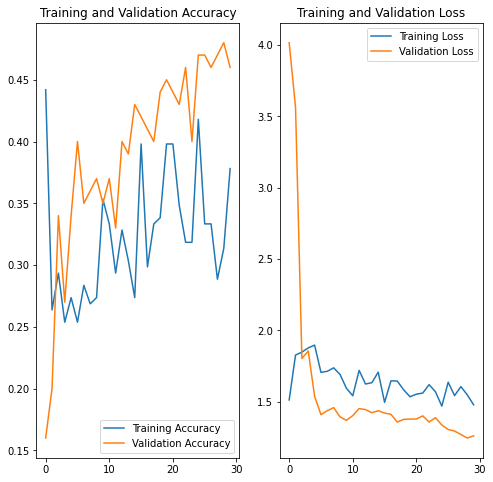

In [50]:
plot(history_conv3d)

### 2.Conv2D+GRU

In [51]:
# #cnv2d +gru
model_Conv2DGRU = Sequential()

model_Conv2DGRU.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(frames,rows,cols,channel)))
model_Conv2DGRU.add(TimeDistributed(BatchNormalization()))
model_Conv2DGRU.add(Dropout(0.25))
model_Conv2DGRU.add(TimeDistributed(MaxPooling2D((2, 2))))
#model_Conv2DGRU.add(Dropout(0.25))

model_Conv2DGRU.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(frames,rows,cols,channel)))
model_Conv2DGRU.add(TimeDistributed(BatchNormalization()))
model_Conv2DGRU.add(Dropout(0.25))
model_Conv2DGRU.add(TimeDistributed(MaxPooling2D((2, 2))))
#model_Conv2DGRU.add(Dropout(0.25))

model_Conv2DGRU.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_Conv2DGRU.add(TimeDistributed(BatchNormalization()))
model_Conv2DGRU.add(Dropout(0.25))
model_Conv2DGRU.add(TimeDistributed(MaxPooling2D((2, 2))))

model_Conv2DGRU.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_Conv2DGRU.add(TimeDistributed(BatchNormalization()))
model_Conv2DGRU.add(Dropout(0.25))
model_Conv2DGRU.add(TimeDistributed(MaxPooling2D((2, 2))))

model_Conv2DGRU.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_Conv2DGRU.add(TimeDistributed(BatchNormalization()))
model_Conv2DGRU.add(Dropout(0.25))
model_Conv2DGRU.add(TimeDistributed(MaxPooling2D((2, 2))))

model_Conv2DGRU.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_Conv2DGRU.add(TimeDistributed(BatchNormalization()))
model_Conv2DGRU.add(Dropout(0.25))
model_Conv2DGRU.add(TimeDistributed(MaxPooling2D((2, 2))))

model_Conv2DGRU.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_Conv2DGRU.add(TimeDistributed(BatchNormalization()))
model_Conv2DGRU.add(Dropout(0.25))
#model_Conv2DGRU.add(TimeDistributed(MaxPooling2D((2, 2))))


model_Conv2DGRU.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_Conv2DGRU.add(TimeDistributed(BatchNormalization()))
model_Conv2DGRU.add(Dropout(0.25))



model_Conv2DGRU.add(TimeDistributed(Flatten()))


model_Conv2DGRU.add(GRU(128,kernel_regularizer=l2(0.01)))
model_Conv2DGRU.add(Dropout(0.2))




model_Conv2DGRU.add(Dense(128,activation='relu'))
model_Conv2DGRU.add(BatchNormalization())
model_Conv2DGRU.add(Dropout(0.5))
model_Conv2DGRU.add(Dense(64,activation='relu'))
model_Conv2DGRU.add(Dropout(0.25))
#model_Conv2DGRU.add(Dense(1, activation='sigmoid'))


model_Conv2DGRU.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam() #write your optimizer
model_Conv2DGRU.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_Conv2DGRU.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_62 (TimeDis (None, 10, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_63 (TimeDis (None, 10, 120, 120, 16)  64        
_________________________________________________________________
dropout_29 (Dropout)         (None, 10, 120, 120, 16)  0         
_________________________________________________________________
time_distributed_64 (TimeDis (None, 10, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_65 (TimeDis (None, 10, 60, 60, 16)    2320      
_________________________________________________________________
time_distributed_66 (TimeDis (None, 10, 60, 60, 16)    64        
_________________________________________________________________
dropout_30 (Dropout)         (None, 10, 60, 60, 16)   

In [52]:
history_Conv2DGRU=model_Conv2DGRU.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 4.2803 - categorical_accuracy: 0.2090
Epoch 00001: val_loss did not improve from 1.24454
67/67 [==============================] - 21s 315ms/step - loss: 4.2803 - categorical_accuracy: 0.2090 - val_loss: 3.3777 - val_categorical_accuracy: 0.1600
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 3.8967 - categorical_accuracy: 0.2438
Epoch 00002: val_loss did not improve from 1.24454
67/67 [==============================] - 20s 304ms/step - loss: 3.8967 - categorical_accuracy: 0.2438 - val_loss: 3.4273 - val_categorical_accuracy: 0.1600
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 3.7112 - categorical_accuracy: 0.2189
Epoch 00003: val_loss did not improve from 1.24454
67/67 [==============================] - 22s 323ms/step - loss: 3.7112 - categorical_accuracy: 0.2189 - val_loss: 3.6424 - val_categorical_accuracy: 0.2100
Epoch 4/30
67/67 [==============================] - ETA: 0s -

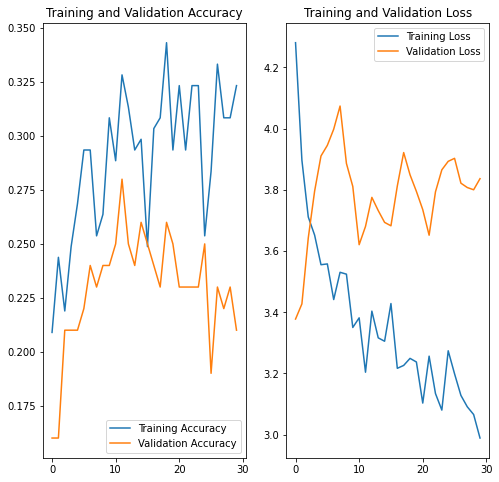

In [53]:
plot(history_Conv2DGRU)

### 3.Conv2D+LSTM

In [54]:
#Conv2D+LSTM
model_conv2DLSTM = Sequential()

model_conv2DLSTM.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(frames,rows,cols,channel)))
model_conv2DLSTM.add(TimeDistributed(BatchNormalization()))
model_conv2DLSTM.add(TimeDistributed(MaxPooling2D((2, 2))))

model_conv2DLSTM.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_conv2DLSTM.add(TimeDistributed(BatchNormalization()))
model_conv2DLSTM.add(TimeDistributed(MaxPooling2D((2, 2))))

model_conv2DLSTM.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_conv2DLSTM.add(TimeDistributed(BatchNormalization()))
model_conv2DLSTM.add(TimeDistributed(MaxPooling2D((2, 2))))

model_conv2DLSTM.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_conv2DLSTM.add(TimeDistributed(BatchNormalization()))
model_conv2DLSTM.add(TimeDistributed(MaxPooling2D((2, 2))))

model_conv2DLSTM.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_conv2DLSTM.add(TimeDistributed(BatchNormalization()))
model_conv2DLSTM.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

model_conv2DLSTM.add(TimeDistributed(Flatten()))


model_conv2DLSTM.add(LSTM(256))
model_conv2DLSTM.add(Dropout(0.5))

model_conv2DLSTM.add(Dense(256,activation='relu'))
model_conv2DLSTM.add(Dropout(0.25))
model_conv2DLSTM.add(Dense(256,activation='relu'))
model_conv2DLSTM.add(Dropout(0.25))
model_conv2DLSTM.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam() #write your optimizer
model_conv2DLSTM.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_conv2DLSTM.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_85 (TimeDis (None, 10, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_86 (TimeDis (None, 10, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_87 (TimeDis (None, 10, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_88 (TimeDis (None, 10, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_89 (TimeDis (None, 10, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_90 (TimeDis (None, 10, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_91 (TimeDis (None, 10, 30, 30, 64)   

In [55]:
history_conv2DLSTM=model_conv2DLSTM.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.7797 - categorical_accuracy: 0.2040
Epoch 00001: val_loss did not improve from 1.24454
67/67 [==============================] - 21s 312ms/step - loss: 1.7797 - categorical_accuracy: 0.2040 - val_loss: 1.6505 - val_categorical_accuracy: 0.1700
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.5761 - categorical_accuracy: 0.2886
Epoch 00002: val_loss did not improve from 1.24454
67/67 [==============================] - 22s 324ms/step - loss: 1.5761 - categorical_accuracy: 0.2886 - val_loss: 1.7166 - val_categorical_accuracy: 0.2200
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.4127 - categorical_accuracy: 0.4080
Epoch 00003: val_loss did not improve from 1.24454
67/67 [==============================] - 21s 313ms/step - loss: 1.4127 - categorical_accuracy: 0.4080 - val_loss: 1.8987 - val_categorical_accuracy: 0.2100
Epoch 4/30
67/67 [==============================] - ETA: 0s -

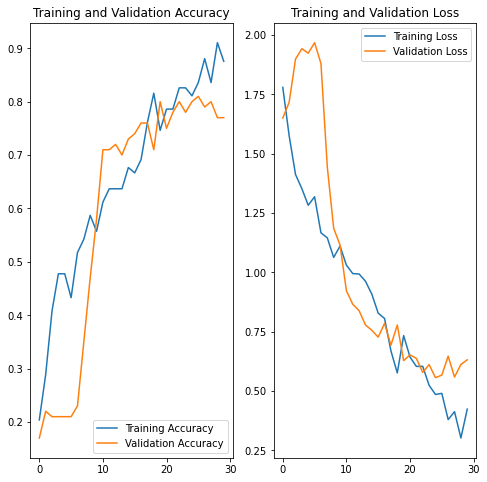

In [56]:
plot(history_conv2DLSTM)

### 4.Transfer Learning:MobileNet +LSTM

In [58]:
# #mobilenet +LSTM--finalmodel
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)


model_transferLSTM = Sequential()
model_transferLSTM.add(TimeDistributed(mobilenet_transfer,input_shape=(10,120,120,3)))


for layer in model_transferLSTM.layers:
    layer.trainable = False


model_transferLSTM.add(TimeDistributed(BatchNormalization()))
model_transferLSTM.add(TimeDistributed(MaxPooling2D((2, 2))))
model_transferLSTM.add(TimeDistributed(Flatten()))

model_transferLSTM.add(LSTM(64))
model_transferLSTM.add(Dropout(.25))

model_transferLSTM.add(Dense(128,activation='relu'))
model_transferLSTM.add(Dropout(0.25))

model_transferLSTM.add(Dense(64,activation='relu'))
model_transferLSTM.add(Dropout(0.25))

model_transferLSTM.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam() #write your optimizer
model_transferLSTM.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_transferLSTM.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_102 (TimeDi (None, 10, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_103 (TimeDi (None, 10, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_104 (TimeDi (None, 10, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_105 (TimeDi (None, 10, 1024)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                278784    
_________________________________________________________________
dropout_43 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)              

In [59]:
history_transferLSTM=model_transferLSTM.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.6126 - categorical_accuracy: 0.2587
Epoch 00001: val_loss did not improve from 0.55632
67/67 [==============================] - 21s 319ms/step - loss: 1.6126 - categorical_accuracy: 0.2587 - val_loss: 1.4192 - val_categorical_accuracy: 0.4700
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.4107 - categorical_accuracy: 0.4378
Epoch 00002: val_loss did not improve from 0.55632
67/67 [==============================] - 22s 322ms/step - loss: 1.4107 - categorical_accuracy: 0.4378 - val_loss: 1.2937 - val_categorical_accuracy: 0.3900
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.3311 - categorical_accuracy: 0.4179
Epoch 00003: val_loss did not improve from 0.55632
67/67 [==============================] - 21s 317ms/step - loss: 1.3311 - categorical_accuracy: 0.4179 - val_loss: 1.0217 - val_categorical_accuracy: 0.6500
Epoch 4/30
67/67 [==============================] - ETA: 0s -

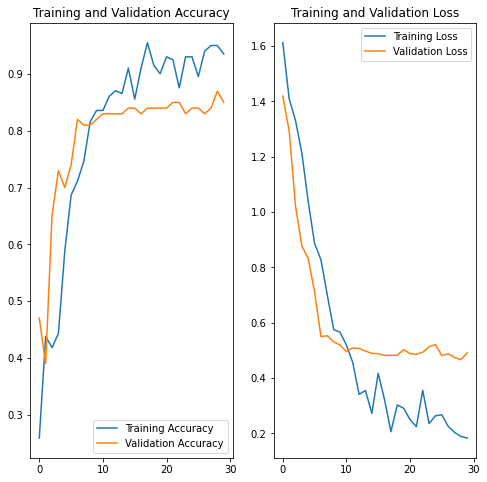

In [68]:
plot(history_transferLSTM)


##### In the final model of Transfer learning and LSTM, 
##### Training Accuracy:0.95
##### Validation Accuracy:0.87
##### Val_Loss=0.46
##### No.Of parameters =297733
##### Hence it is by far the best and most optimum model for gesture recognition